### Edge Activation Graphs

#### Imports

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from importlib import reload
from src import create_fake_patients, whole_model_demographics_gradcam, graph_plot, plot_feature_value, ga

#### Set up model hyperparameters

In [5]:
second_TGCNN_layer = True
demo = True


stride = 1
filter_size = 4
num_filters = 16
years_in_advance = '5'
hip_or_knee='hip'
max_timesteps=100
include_drugs = True
if include_drugs:
    max_event_codes = 518
else:
    max_event_codes = 512

# fake mapping dataframe for the ReadCodes and the corresponding descriptions
read_code_map_df = pd.read_csv('fake_read_code_descriptions.csv')

model = whole_model_demographics_gradcam.TGCNN_Model(num_filters=num_filters, num_nodes=max_event_codes, num_time_steps=max_timesteps, 
                            filter_size=filter_size, variable_gamma=True, 
                            exponential_scaling=True, dropout_rate=0.7, lstm_units=64,
                            fcl1_units=128, LSTM_ablation=False, stride=stride, activation_type='LeakyReLU', 
                            no_timestamp=False, second_TGCNN_layer=second_TGCNN_layer, num_labels=1)
model.load_weights('hip_1999_to_one_year_advance_model1_CNN_layer')

# Load in the filters from the model
with open('hip_1999_to_one_year_advance_model1_filter.npy', 'rb') as f:
    filters = np.load(f)


### Find the filter with the largest activation

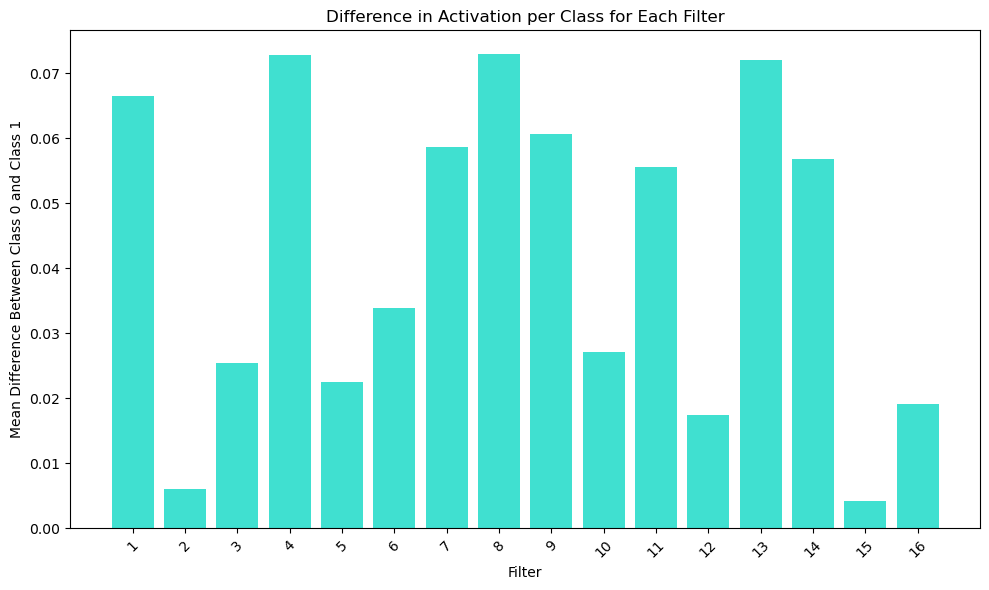

In [6]:
num_patients = 10

pat_df = create_fake_patients.create_fake_patient_df(num_patients=num_patients, 
                                                     max_events=max_timesteps-1, 
                                                     max_nodes=max_event_codes)

replacement_true_lst, max_w_filt_lst, filt_nums = ga.get_act_metric_per_feat(model, num_filters, num_patients, 
                                                                             pat_df, max_event_codes, hip_or_knee,
                                                                             'max')
mean_activation_df = ga.act_diff(replacement_true_lst, max_w_filt_lst, filt_nums)

In [7]:
max_act_filt_num = ga.find_max_act_filt(mean_activation_df)
max_act_filt_num

8

In [8]:
# Generate individual data for the model
input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0)
logits = model(input_4d, demo_tensor, training=False)
dense_tensor = tf.sparse.to_dense(input_3d)
dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
dense_tensor = np.flip(dense_tensor, axis=0) # change the most recent events to be at the end rather than the start

In [9]:
filters_4d = ga.make_filts_4d(filters, filter_size, max_event_codes)
filters_4d.shape

(16, 518, 518, 4)

In [13]:
f

<tf.Tensor: shape=(4, 518, 518), dtype=float32, numpy=
array([[[ 1.39500629e-02, -1.46406647e-02,  2.72638611e-02, ...,
         -1.45746041e-02, -4.84208576e-03, -1.26745994e-03],
        [ 4.09210473e-03,  1.36829559e-02,  5.88988885e-03, ...,
         -2.02070102e-02,  8.23219400e-03, -1.93118788e-02],
        [ 5.83515642e-03,  1.51679087e-02, -7.50413490e-03, ...,
          1.36294367e-03, -2.88286130e-03, -2.35362910e-02],
        ...,
        [ 3.87903070e-03, -5.18329814e-03,  2.03836225e-02, ...,
         -2.29825713e-02, -6.45792461e-04,  1.79091524e-02],
        [ 8.02142173e-03, -3.88945639e-03, -4.46689688e-03, ...,
         -1.43244015e-02, -1.44328028e-02, -1.62970349e-02],
        [ 1.51533084e-02, -9.11860913e-03,  9.09239706e-03, ...,
          2.40599327e-02,  7.26024015e-03,  1.39235556e-02]],

       [[-2.00197455e-02,  1.54710803e-02, -4.22306405e-03, ...,
         -1.88666768e-02, -1.84342358e-03, -9.45353881e-03],
        [-2.26588547e-02, -9.80104879e-03, -5.69

In [15]:
f = ga.get_and_reshape_filt(filters_4d, max_act_filt_num, filt_type='median')
f = tf.cast(f, dtype=tf.float16)
    
edge_act_graph = ga.filt_times_pat(f, dense_tensor, filter_size, max_timesteps, stride)

In [16]:
edges_df = ga.create_edges_df_ga(dense_tensor, edge_act_graph) 

In [17]:
# Get the node positions for the graph
pos_df = graph_plot.create_position_df_gc(edges_df)
pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

read_code_pos_df = ga.map_read_code_labels(pos_df, read_code_map_df)

edge_pos_df = ga.create_edge_pos_df(edges_df, pos_df)

In [10]:
ga.plot_edge_act_plotly(edge_pos_df, pos_df, read_code_pos_df, years_in_advance, logits, outcome, filename='edge_activation_graph', html_open=False)

In [19]:
edge_pos_df

,start_node,end_node,time_between,edge_weights,x0,y0,node_num_x,x1,y1,node_num_y,edge_weight_perc
0,319_v0,224_v1,0.043719,0.000000,0,0,319,1,0,224,0.000000
1,224_v1,48_v2,0.798690,0.000000,1,0,224,2,0,48,0.000000
2,48_v2,248_v3,0.463859,0.000000,2,0,48,3,0,248,0.000000
3,248_v3,300_v4,0.914310,0.010483,3,0,248,4,0,300,7.424440
4,300_v4,117_v5,0.869272,0.000000,4,0,300,5,0,117,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
92,57_v92,303_v93,0.338228,0.000636,92,0,57,93,0,303,0.450181
93,303_v93,331_v94,0.490911,0.005150,93,0,303,94,0,331,3.647378
94,331_v94,255_v95,0.035818,0.000276,94,0,331,95,0,255,0.195202
95,255_v95,69_v96,0.568869,0.000000,95,0,255,96,0,69,0.000000


In [41]:
def replace_visit_number(original_list):
    original_versions = []
    for tpl in original_list:
        for item in tpl:
            version = item.split('_')[1]  # Extract the version number part (e.g., 'v91')
            original_versions.append(version)

    # Create a mapping from original version numbers to new version numbers starting from 1
    unique_versions = sorted(set(original_versions), key=lambda x: int(x[1:]))
    version_mapping = {v: f"v{i+1}" for i, v in enumerate(unique_versions)}

    # Replace the version numbers in the original tuples
    new_list = [
        (
            f"{item1.split('_')[0]}_{version_mapping[item1.split('_')[1]]}",
            f"{item2.split('_')[0]}_{version_mapping[item2.split('_')[1]]}"
        )
        for item1, item2 in original_list
    ]
    return new_list

def add_tuples_to_dict(tuples_list, subgraph_dict):
    # Sort each tuple within the list to ensure consistent ordering
    sorted_tuples = sorted(tuple(tpl for tpl in tuples_list))
    #print("sorted_tuples", sorted_tuples)
    # Convert the sorted list of tuples into a tuple (to use as a dictionary key)
    key = tuple(sorted_tuples)
    #print("key", key)
    # add 1 to the count in the dictionary
    subgraph_dict[key] += 1


from collections import defaultdict

subgraph_dict = defaultdict(int)

# Remove repeat rows where edge_weight_perc == 0
mask = edge_pos_df['edge_weight_perc'] != edge_pos_df['edge_weight_perc'].shift()
df_unique_adjacent = edge_pos_df[mask].reset_index(drop=True)

# Find indices where the edge_weight_perc col has a value of 0
split_indices = df_unique_adjacent.index[df_unique_adjacent['edge_weight_perc'] == 0].tolist()

# Add start and end indices to make it easier to split
split_indices = [-1] + split_indices + [len(df_unique_adjacent)]

# Split the DataFrame into chunks
chunks = [df_unique_adjacent.iloc[split_indices[i]+1:split_indices[i+1]] for i in range(len(split_indices)-1)]

for i, chunk in enumerate(chunks):
    if len(chunk) != 0:
        #print(f"Subgraph {i}:\n", chunk, "\n")
        subgraph_list = list(zip(chunk['start_node'], chunk['end_node']))
        #print(subgraph_list)
        subgraph_list_adj_vis = replace_visit_number(subgraph_list)
        print(subgraph_list_adj_vis)
        add_tuples_to_dict(subgraph_list_adj_vis, subgraph_dict)

subgraph_dict

[('248_v1', '300_v2')]
[('117_v1', '88_v2')]
[('282_v1', '259_v2'), ('259_v2', '420_v3')]
[('474_v1', '168_v2'), ('168_v2', '338_v3'), ('338_v3', '371_v4'), ('371_v4', '232_v5')]
[('252_v1', '365_v2'), ('365_v2', '211_v3')]
[('510_v1', '338_v2'), ('338_v2', '431_v3')]
[('312_v1', '56_v2'), ('56_v2', '84_v3')]
[('366_v1', '86_v2'), ('86_v2', '388_v3')]
[('78_v1', '77_v2'), ('77_v2', '454_v3')]
[('168_v1', '376_v2')]
[('12_v1', '119_v2')]
[('496_v1', '191_v2'), ('191_v2', '223_v3')]
[('490_v1', '238_v2')]
[('297_v1', '119_v2')]
[('279_v1', '2_v2'), ('2_v2', '459_v3')]
[('129_v1', '414_v2')]
[('358_v1', '126_v2')]
[('440_v1', '466_v2')]
[('132_v1', '471_v2'), ('471_v2', '166_v3'), ('166_v3', '61_v4'), ('61_v4', '12_v5')]
[('140_v1', '497_v2')]
[('58_v1', '74_v2'), ('74_v2', '423_v3')]
[('170_v1', '468_v2'), ('468_v2', '48_v3'), ('48_v3', '364_v4')]
[('472_v1', '488_v2'), ('488_v2', '279_v3')]
[('59_v1', '102_v2')]
[('395_v1', '57_v2'), ('57_v2', '303_v3'), ('303_v3', '331_v4'), ('331_v4',

defaultdict(int,
            {(('248_v1', '300_v2'),): 1,
             (('117_v1', '88_v2'),): 1,
             (('259_v2', '420_v3'), ('282_v1', '259_v2')): 1,
             (('168_v2', '338_v3'),
              ('338_v3', '371_v4'),
              ('371_v4', '232_v5'),
              ('474_v1', '168_v2')): 1,
             (('252_v1', '365_v2'), ('365_v2', '211_v3')): 1,
             (('338_v2', '431_v3'), ('510_v1', '338_v2')): 1,
             (('312_v1', '56_v2'), ('56_v2', '84_v3')): 1,
             (('366_v1', '86_v2'), ('86_v2', '388_v3')): 1,
             (('77_v2', '454_v3'), ('78_v1', '77_v2')): 1,
             (('168_v1', '376_v2'),): 1,
             (('12_v1', '119_v2'),): 1,
             (('191_v2', '223_v3'), ('496_v1', '191_v2')): 1,
             (('490_v1', '238_v2'),): 1,
             (('297_v1', '119_v2'),): 1,
             (('279_v1', '2_v2'), ('2_v2', '459_v3')): 1,
             (('129_v1', '414_v2'),): 1,
             (('358_v1', '126_v2'),): 1,
             (('440_v1', 

In [59]:
# Convert the defaultdict into a df for easier reading/analysis
flattened_data = []
for key, value in subgraph_dict.items():
    flattened_key = list(sublist for sublist in key)
    flattened_data.append((flattened_key, value))

subgraph_df = pd.DataFrame(flattened_data, columns=['Subgraph', 'Count']).sort_values(by='Count', ascending=False)

subgraph_df

,Subgraph,Count
0,"[(248_v1, 300_v2)]",1
13,"[(297_v1, 119_v2)]",1
23,"[(59_v1, 102_v2)]",1
22,"[(472_v1, 488_v2), (488_v2, 279_v3)]",1
21,"[(170_v1, 468_v2), (468_v2, 48_v3), (48_v3, 36...",1
20,"[(58_v1, 74_v2), (74_v2, 423_v3)]",1
19,"[(140_v1, 497_v2)]",1
18,"[(132_v1, 471_v2), (166_v3, 61_v4), (471_v2, 1...",1
17,"[(440_v1, 466_v2)]",1
16,"[(358_v1, 126_v2)]",1


In [23]:
reload(create_fake_patients)
filt_type = 'median'

sensitivity_list = []
for pat in range(2):
    input_3d, input_4d, demo_tensor, outcome, outcome_bin = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0) # REPLACE WITH CV_PATIENTS AND PAT NUMBER

    dense_tensor = tf.sparse.to_dense(input_3d)
    dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
    dense_tensor = np.flip(dense_tensor, axis=0)
    filters_4d = ga.make_filts_4d(filters, filter_size, max_event_codes)

    f = ga.get_and_reshape_filt(filters_4d, 30, filt_type=filt_type)
    
    edge_act_graph = ga.filt_times_pat(f, dense_tensor, filter_size, max_timesteps, stride)
    edges_df = ga.create_edges_df_ga(dense_tensor, edge_act_graph) 
    
    # Get the node positions for the graph
    pos_df = graph_plot.create_position_df_gc(edges_df)
    pos_list = graph_plot.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
    pos_df = graph_plot.map_y_coord_to_node(pos_df, pos_list)

    #read_code_pos_df = ga.map_read_code_labels(pos_df, read_code_map_df)

    edge_pos_df = ga.create_edge_pos_df(edges_df, pos_df)

    v_mod_list, v_orig_list = [], []
    for i in range(1):
        input_3d, input_4d, demo_tensor, outcome, outcome_bin, edge_num = create_fake_patients.return_fake_pat(2, 99, 518, 'hip', 0, change_node=True) # REPLACE WITH CV_PATIENTS AND PAT NUMBER

        dense_tensor = tf.sparse.to_dense(input_3d)
        dense_tensor= tf.transpose(dense_tensor, perm=[2, 1, 0])
        dense_tensor_p = np.flip(dense_tensor, axis=0)
        filters_4d = ga.make_filts_4d(filters, filter_size, max_event_codes)

        f = ga.get_and_reshape_filt(filters_4d, 30, filt_type=filt_type)
        
        p_edge_act_graph = ga.filt_times_pat(f, dense_tensor_p, filter_size, max_timesteps, stride)
        p_edges_df = ga.create_edges_df_ga(dense_tensor_p, p_edge_act_graph) 
        
        # Get the node positions for the graph
        p_pos_df = graph_plot.create_position_df_gc(p_edges_df)
        p_pos_list = graph_plot.generate_pos_sequence(p_pos_df['max_codes_per_visit'].max())
        p_pos_df = graph_plot.map_y_coord_to_node(p_pos_df, p_pos_list)

        #read_code_pos_df = ga.map_read_code_labels(p_pos_df, read_code_map_df)

        p_edge_pos_df = ga.create_edge_pos_df(p_edges_df, p_pos_df)

        # CODE HERE TO GET MODIFIED AND ORIGINAL EDGE WEIGHT PERCENTAGES
        mod_edge_infl = p_edge_pos_df.iloc[-edge_num]['edge_weight_perc'] # negative needed as the order flips
        orig_edge_infl = edge_pos_df.iloc[-edge_num]['edge_weight_perc']

        v_mod_list.append(mod_edge_infl)
        v_orig_list.append(orig_edge_infl)




    l1_norm = np.sum(np.abs(np.array(v_mod_list) - np.array(v_orig_list)))
    ave_l1_norm = l1_norm / 50
    #print(ave_l1_norm)
    sensitivity_list.append(ave_l1_norm)   

print(f"Sensitivity mean +- std: {np.mean(sensitivity_list)}$\pm${np.std(sensitivity_list)}")    

IndexError: single positional indexer is out-of-bounds